In [1]:
from collections import defaultdict
from sklearn.metrics import roc_curve, f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import ast
import tqdm
import numpy as np

from trainer import config
from classification import MultiLabelClassificationHead

c:\Users\alexs\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_df = pd.read_csv('./data/CTP10/test.csv', index_col=0, encoding='utf8')
test_df.head()

,time_limit,memory_limit,description,tags,language
Unnamed: 0,,,,,
1455/B,1.0,256.0,stand $$$ \mathit { ox } $$$ -axis point $$$ 0...,"['constructivealgorithms', 'math']",en
1173/A,1.0,256.0,nauuo a girl love write comment one day post a...,['greedy'],en
1612/A,3.0,512.0,let 's denote manhattan distance two point $$$...,"['bruteforce', 'constructivealgorithms']",en
1113/A,1.0,256.0,sasha a happy guy 's always move $$$ n $$$ cit...,"['dp', 'greedy', 'math']",en
294/A,2.0,256.0,shaass decide hunt bird n horizontal electrici...,"['implementation', 'math']",en


In [3]:
new_test_idx = [] 
selected_test_tags = [] 

for index in test_df.index:
    check = 0
    t = []  

    for tag in ast.literal_eval(test_df.loc[index]['tags']):
        if tag in config['tags']:
            check = 1
            t.append(tag)

    if check == 1:
        selected_test_tags.append(t)
        new_test_idx.append(index)

print(len(new_test_idx)) 

325


In [4]:
test_df = test_df.loc[new_test_idx]
test_df['tags'] = selected_test_tags

In [5]:
X_test = test_df['description']
y_tags_test = test_df['tags']

In [7]:
tag_label_encoder = MultiLabelBinarizer()

y_tags_test = tag_label_encoder.fit_transform(y_tags_test)

In [8]:
def tokenizing(tokenizer, data, max_length):
    data = list(data.values)
    tokenized_data = tokenizer(data, padding=True, truncation=True, return_tensors='pt', max_length=max_length)

    return tokenized_data

def convert_to_tensor(data, dtype):
    tensor_data = torch.tensor(data, dtype=dtype)
    return tensor_data

In [9]:
tokenizer = config['tokenizer']

In [10]:
tokenized_inputs_test = tokenizing(tokenizer, X_test, config['validMaxLength'])
tags_labels_test = convert_to_tensor(y_tags_test, dtype=torch.float)

In [11]:
state = torch.load('./model.pt')
num_classes = len(config['tags'])

In [12]:
model_state_dict = {}
tag_state_dict = {}

In [13]:
for k, v in state.items():
    if "model." in k:
        name = k[6:]
        model_state_dict[name] = v
    if "tags_classifier." in k:
        name = k[len("tags_classifier."):]
        tag_state_dict[name] = v

In [14]:
model = config['model']
tag_head = MultiLabelClassificationHead(num_classes)

In [15]:
model.load_state_dict(model_state_dict)
tag_head.load_state_dict(tag_state_dict)

<All keys matched successfully>

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
tag_head.to(device)
print('device : ', device)

device :  cpu


In [17]:
test_dataset = TensorDataset(tokenized_inputs_test['input_ids'], tokenized_inputs_test['attention_mask'], tags_labels_test)
test_dataloader = DataLoader(test_dataset, batch_size=config['batchSize'], shuffle=False, num_workers=8, pin_memory=True)

100%|██████████| 82/82 [17:56<00:00, 13.13s/it]


bruteforce : 0.5343392945851961
constructivealgorithms : 0.6046151337247228
datastructures : 0.5574534161490683
dfsandsimilar : 0.397196261682243
dp : 0.5329454545454546
geometry : 0.6413292589763178
greedy : 0.6207375599898964
implementation : 0.6042099592088048
math : 0.6526697312588402
strings : 0.6792194879443201

tag_roc_auc_score :  0.5824715558064865
f1_score :  0.3080225264908538
threshold :  0.001


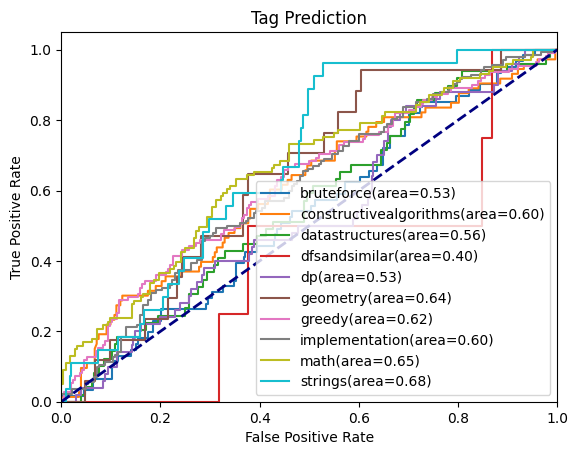

In [18]:
model.eval()
tag_head.eval()
with torch.no_grad():

    thresholds = [0.001] + [i * 0.01 for i in range(1, 101)]
    tags_true = []
    tags_pred = defaultdict(list)
    tags_pred_proba = []

    for batch in tqdm.tqdm(test_dataloader):
        input_ids, attention_mask, tags_labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        tags_labels = tags_labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        tags_output = tag_head(pooled_output)

        tags_true.extend([torch.nonzero(row).flatten().tolist() for row in tags_labels.detach().cpu().clone()])
        tags_pred_proba.extend(tags_output.detach().cpu().clone().tolist())

        for threshold in thresholds:
            tags_pred[threshold].extend([(row >= threshold).nonzero().flatten().tolist() for row in tags_output.detach().cpu().clone()])


    tag_true = []

    for index_list in tags_true:
        result_true = [0] * num_classes
        for index in index_list:
            result_true[index] = 1 

        tag_true.append(result_true)

    tag_true = np.array(tag_true)
    tags_pred_proba = np.array(tags_pred_proba)

    thr = 0
    max_f1_score = 0

    for threshold in thresholds:
        tag_pred = []
        for index_list in tags_pred[threshold]:
            result_pred = [0] * num_classes
            for index in index_list:
                result_pred[index] = 1 

            tag_pred.append(result_pred)

        f1 = f1_score(tag_true, tag_pred, average='macro', zero_division=0)
        if max_f1_score < f1:
            thr = threshold
            max_f1_score = f1

    fpr = dict()
    tpr = dict()

    # Plot ROC curve for each classifier
    plt.figure()
    for tag in range(num_classes):
        tt, tp = tag_true[:, tag], tags_pred_proba[:, tag]

        score = roc_auc_score(tt, tp)
        tag = tag_label_encoder.classes_[tag]
        print(f"{tag} : {score}")
        fpr[tag], tpr[tag], _ = roc_curve(tt, tp)
        plt.plot(fpr[tag], tpr[tag], label=f'{tag}(area={score:.2f})')
    print()

    print("tag_roc_auc_score : ", roc_auc_score(tag_true, tags_pred_proba))
    print("f1_score : ", max_f1_score)
    print("threshold : ", thr)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Tag Prediction')
    plt.legend(loc="lower right")
    plt.show()
     